 _This notebook is about text analytics on news articles. Our work includes two parts: the first part is topic-specific news scrapping from a list of credible mainstream media, and the second part is clustering analysis and sentiment detection on the scrapped news articles. This notebook is cowritten by **dizhu1991** (https://github.com/dizhu1991) and **devanshjani** (https://github.com/devanshjani). Di mainly contributed to the data extraction, and Devansh mainly contributed to the analysis and visualisation._

Before starting the news scrapping, we import some libraries, including **pandas**, **newspaper** and **nltk**.

In [3]:
import feedparser as fp
import json
import newspaper
from newspaper import Article
from time import mktime
from datetime import datetime
import pandas as pd
import nltk as nlp
from nltk.tag.stanford import StanfordNERTagger as nert

### Now we start the first part: news extration.

In [4]:
# Set the limit for number of articles to download
# It will actually download fewer articles due to RSS feed limitation.
total_limit = 1000

In [5]:
data = {} #Empty dict variable to store the articles
data['newspapers'] = {}
news = pd.DataFrame([],columns=['Title','Text','Link','Published','Type'])

In [6]:
# Loads the JSON files with news sites
with open('NewsPapers.json') as data_file:
    companies = json.load(data_file)

We loaded a .json file containing the media outlets we are extracting articles from. The .json includes the links and RSS feeds (if available).

In [7]:
companies

{'ABC News': {'link': 'https://abcnews.go.com/',
  'rss': 'https://abcnews.go.com/abcnews/topstories'},
 'AP': {'link': 'https://apnews.com/',
  'rss': 'http://hosted.ap.org/lineups/USHEADS-rss_2.0.xml?SITE=RANDOM&SECTION=HOME'},
 'BBC World News': {'link': 'http://www.bbc.com/',
  'rss': 'http://feeds.bbci.co.uk/news/world/rss.xml'},
 'Buzzfeed News Politics': {'link': 'https://www.buzzfeed.com/politics',
  'rss': 'https://www.buzzfeed.com/politics.html'},
 'CNN': {'link': 'http://edition.cnn.com/',
  'rss': 'http://rss.cnn.com/rss/cnn_topstories.rss'},
 'Fox News Latest': {'link': 'www.foxnews.com',
  'rss': 'http://feeds.foxnews.com/foxnews/latest?format=xml'},
 'NBC News top stories': {'link': 'https://www.nbcnews.com/',
  'rss': 'http://feeds.nbcnews.com/feeds/topstories'},
 'NPR News': {'link': 'www.npr.org',
  'rss': 'https://www.npr.org/rss/rss.php?id=1003'},
 'NY Times': {'link': 'https://www.nytimes.com/',
  'rss': 'http://feeds.nytimes.com/nyt/rss/HomePage'},
 'New Yorker': 

Now we define a function to determine if a sentence has a specified keyword. In this notebook, the keyword is _**Trump**_.

In [8]:
def contains_word(s, w):
    return w in s # Will try to change to regex later. 
    #return f' {w} ' in f' {s} '

In [9]:
KEY_WORD = "Trump"

Next is the main function of scrapping news articles into a list. Only articles that have the keyword "Trump" in either its **title** or **summary** are extracted, and extracted articles are appended to a list. Then the list would be structed into a pandas dataframe.

In [10]:
def single_download(lst, count, company, value, LIMIT, Keyword):
    if 'rss' in value:
        d = fp.parse(value['rss'])
        print("Downloading articles from ", company)
        newsPaper = {
            "rss": value['rss'],
            "link": value['link'],
            "articles": []
        }
        for entry in d.entries:
            # Check if publish date is provided, if no the article is skipped.
            # This is done to keep consistency in the data and to keep the script from crashing.
            try:
                if entry.title is None:
                    entry_title = " "
                else:
                    entry_title = entry.title
                if entry.summary is None:
                    entry_summary = " "
                else:
                    entry_summary = entry.summary
                if hasattr(entry, 'published') and (contains_word(entry_title, Keyword) or contains_word(entry_summary, Keyword)):
                    if count > LIMIT:
                        break
                    article = {}
                    article['link'] = entry.link
                    date = entry.published_parsed
                    article['published'] = datetime.fromtimestamp(mktime(date)).isoformat()
                    try:
                        content = Article(entry.link)
                        content.download()
                        content.parse()
                    except Exception as e:
                        # If the download for some reason fails (ex. 404) the script will continue downloading
                        # the next article.
                        print(e)
                        print("continuing...")
                        continue
                    article['title'] = content.title
                    article['text'] = content.text
                    newsPaper['articles'].append(article)

                    lst.append([content.title,content.text,content.url,datetime.fromtimestamp(mktime(date)).isoformat(),'RSS'])

                    print(count, "articles downloaded from", company, ", url: ", entry.link)
                    count = count + 1
                    news
            except Exception as e:
                print(e)
                print("continuing...")
                continue


    else:
        # This is the fallback method if a RSS-feed link is not provided.
        # It uses the python newspaper library to extract articles
        print("Building site for ", company)
        paper = newspaper.build(value['link'], memoize_articles=False)
        newsPaper = {
            "link": value['link'],
            "articles": []
        }
        noneTypeCount = 0
        for content in paper.articles:
            if count > LIMIT:
                break
            try:
                content.download()
                content.parse()
            except Exception as e:
                print(e)
                print("continuing...")
                continue
            # Again, for consistency, if there is no found publish date the article will be skipped.
            # After 10 downloaded articles from the same newspaper without publish date, the company will be skipped.
            if contains_word(content.title, Keyword) or contains_word(content.summary, Keyword):
                if content.publish_date is None:
                    print(count, " Article has date of type None...")
                    noneTypeCount = noneTypeCount + 1
                    if noneTypeCount > 10:
                        print("Too many noneType dates, aborting...")
                        noneTypeCount = 0
                        break
                    count = count + 1
                    continue
                article = {}
                article['title'] = content.title
                article['text'] = content.text
                article['link'] = content.url
                article['published'] = content.publish_date.isoformat()

                lst.append([content.title,content.text,content.url,content.publish_date.isoformat(),'News'])

                newsPaper['articles'].append(article)
                print(count, "articles downloaded from", company, " using newspaper, url: ", content.url)
                count = count + 1
                noneTypeCount = 0
                news


news_list is what we use to store the extracted articles.

In [ ]:
news_list = []
ttl_ct = 1
for company, value in companies.items():
    single_download(news_list, ttl_ct, company, value, total_limit, KEY_WORD)

In [ ]:
news_4 = pd.DataFrame(news_list,columns=['Title','Text','Link','Published','Type'])

In [11]:
def get_author(news_df):
    author_list = []
    for link in news_df['Link']:
        article = Article(link)
        article.download()
        article.parse()
        author_list.append(article.authors)
    return author_list

Now we load the dataset we scrapped right after the North Korean summit, and extract the authors with news links in the 'Link" column. For the articles without authors, their author names will be 'Not Found'.

In [12]:
news_4 = pd.read_pickle("/Users/grandmoon/Documents/news_4.pkl")
news_5 = news_4.drop(['Authors'],axis=1)

In [ ]:
news_5['Authors'] = authors_news_5

news_5.Authors = news_5.Authors.apply(lambda y: ['Not Found'] if len(y) == 0 else y)

We have saved news_5 to csv before, so here we just read the csv file and show its first 5 rows.

In [13]:
news_5 = pd.read_csv("/Users/grandmoon/Documents/news_5.csv")
news_5 = news_5.drop(['Unnamed: 0'], axis=1)

In [14]:
news_5.head()

,Title,Text,Link,Published,Type,Authors
0,Why North Koreans were last to learn of Trump-...,Why North Koreans last to learn of summit\n\nT...,https://www.bbc.co.uk/news/world-asia-44473807,2018-06-13T14:57:40,RSS,['Not Found']
1,Sarah Sanders rumoured to be leaving White Hou...,Image copyright EPA Image caption Sarah Sander...,https://www.bbc.co.uk/news/world-us-canada-444...,2018-06-14T08:06:59,RSS,"['Tara Mckelvey', 'Bbc White House Reporter']"
2,Trump Kim summit: Imagine a North Korean family,Image copyright Hajung Lim\n\nAfter his landma...,https://www.bbc.co.uk/news/world-asia-44164948,2018-06-14T00:10:00,RSS,"['Andreas Illmer', 'Bbc News']"
3,Trump's immigration policy comes into focus in...,(CNN) America is heading for a moment of recko...,http://rss.cnn.com/~r/rss/cnn_topstories/~3/Ks...,2018-06-14T05:12:37,RSS,['Analysis Stephen Collinson']
4,500+ immigrant children separated from parents,More than 500 immigrant children have been sep...,http://rss.cnn.com/~r/rss/cnn_topstories/~3/1I...,2018-06-12T22:04:07,RSS,['Not Found']


### After getting the news articles, we'll start the analysis on dataset news_5.

Still, we'll import some libraries first, including tools from **nltk** and **sklearn** as well as clustering packages.

In [5]:
import re, string, unicodedata
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from __future__ import print_function
from nltk.stem.snowball import SnowballStemmer
import itertools
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud
stemmer = SnowballStemmer("english")

In [ ]:
news_article = pd.read_csv("/Users/devanshjani/Downloads/news_5.csv")
old_news = pd.read_csv("/Users/devanshjani/Downloads/total_news.csv")

In [4]:
news_article.reset_index(inplace=True)

Let's see an example of the extracted articles.

In [5]:
news_article['Text'][1]

'Image copyright EPA Image caption Sarah Sanders has been President Trump\'s press secretary for a year\n\nSarah Huckabee Sanders, the White House press secretary, is planning to leave the administration, according to one US media outlet.\n\nMs Sanders responded to the story with a statement on social media saying she knew nothing about the story, but did not deny its accuracy. It all seemed very Trumpian.\n\nFirst CBS News reported that Sanders and deputy press secretary Raj Shah was getting ready to head for the exit.\n\nMs Sanders responded shortly afterwards, on Twitter, in an indignant manner.\n\nSkip Twitter post by @PressSec Does @CBSNews know something I don’t about my plans and my future? I was at my daughter’s year-end Kindergarten event and they ran a story about my “plans to leave the WH” without even talking to me. I love my job and am honored to work for @POTUS — Sarah Sanders (@PressSec) June 14, 2018 Report\n\nYet she does not say that the report is inaccurate. She just

In [6]:
news_article['tokenized_sents'] = news_article.apply(lambda row: nlp.word_tokenize(row['Text']), axis=1)

In [7]:
news_article.shape

(93, 9)

In [8]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word) 
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words

def cleartext(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return itertools.chain.from_iterable(words)

In [9]:
news_article['processed'] = news_article.apply(lambda row: normalize(row['tokenized_sents']), axis=1)

In [10]:
news_article['freq'] = news_article.apply(lambda row: nlp.FreqDist(row['processed']), axis=1)

In [11]:
news_article['cleantext'] = news_article.apply(lambda row: ' '.join(row['processed']), axis=1)

In [12]:
news_article['cleantitle'] = news_article.apply(lambda row: ' '.join(normalize(nlp.word_tokenize(row['Title']))), axis=1)

In [13]:
#news_article['cleantitle'][1]
news_article['maintitle'] = news_article.apply(lambda row: row['cleantitle'][:25] + (row['cleantitle'][25:] and '..'), axis=1)


In [14]:
news_article['maintitle'] = news_article.apply(lambda row: row['maintitle'].strip(), axis=1)

In [57]:
news_article

,index,Unnamed: 0,Title,Text,Link,Published,Type,Authors,tokenized_sents,processed,freq,cleantext,cleantitle,maintitle
0,0,0,Why North Koreans were last to learn of Trump-...,Why North Koreans last to learn of summit\n\nT...,https://www.bbc.co.uk/news/world-asia-44473807,2018-06-13T14:57:40,RSS,['Not Found'],"[Why, North, Koreans, last, to, learn, of, sum...","[north, koreans, last, learn, summit, people, ...","{'north': 2, 'koreans': 1, 'last': 2, 'learn':...",north koreans last learn summit people north k...,north koreans last learn trumpkim summit,north koreans last learn ..
1,1,1,Sarah Sanders rumoured to be leaving White Hou...,Image copyright EPA Image caption Sarah Sander...,https://www.bbc.co.uk/news/world-us-canada-444...,2018-06-14T08:06:59,RSS,"['Tara Mckelvey', 'Bbc White House Reporter']","[Image, copyright, EPA, Image, caption, Sarah,...","[image, copyright, epa, image, caption, sarah,...","{'image': 4, 'copyright': 2, 'epa': 1, 'captio...",image copyright epa image caption sarah sander...,sarah sanders rumoured leaving white house pre...,sarah sanders rumoured le..
2,2,2,Trump Kim summit: Imagine a North Korean family,Image copyright Hajung Lim\n\nAfter his landma...,https://www.bbc.co.uk/news/world-asia-44164948,2018-06-14T00:10:00,RSS,"['Andreas Illmer', 'Bbc News']","[Image, copyright, Hajung, Lim, After, his, la...","[image, copyright, hajung, lim, landmark, meet...","{'image': 3, 'copyright': 3, 'hajung': 3, 'lim...",image copyright hajung lim landmark meeting le...,trump kim summit imagine north korean family,trump kim summit imagine ..
3,3,3,Trump's immigration policy comes into focus in...,(CNN) America is heading for a moment of recko...,http://rss.cnn.com/~r/rss/cnn_topstories/~3/Ks...,2018-06-14T05:12:37,RSS,['Analysis Stephen Collinson'],"[(, CNN, ), America, is, heading, for, a, mome...","[cnn, america, heading, moment, reckoning, res...","{'cnn': 1, 'america': 3, 'heading': 1, 'moment...",cnn america heading moment reckoning results y...,trump immigration policy comes focus politics,trump immigration policy ..
4,4,4,500+ immigrant children separated from parents,More than 500 immigrant children have been sep...,http://rss.cnn.com/~r/rss/cnn_topstories/~3/1I...,2018-06-12T22:04:07,RSS,['Not Found'],"[More, than, 500, immigrant, children, have, b...","[five hundred, immigrant, children, separated,...","{'five hundred': 1, 'immigrant': 1, 'children'...",five hundred immigrant children separated pare...,five hundred immigrant children separated parents,five hundred immigrant ch..
5,5,5,Catholic leader calls separating mothers and c...,Washington (CNN) The president of the US Confe...,http://rss.cnn.com/~r/rss/cnn_topstories/~3/YS...,2018-06-13T23:54:56,RSS,['Clare Foran'],"[Washington, (, CNN, ), The, president, of, th...","[washington, cnn, president, us, conference, c...","{'washington': 1, 'cnn': 2, 'president': 3, 'u...",washington cnn president us conference catholi...,catholic leader calls separating mothers child...,catholic leader calls sep..
6,6,6,President Trump's legal team plots next move f...,Washington (CNN) As he flew back from the hist...,http://rss.cnn.com/~r/rss/cnn_topstories/~3/di...,2018-06-14T02:00:05,RSS,"['Dana Bash', 'Gloria Borger', 'Evan Perez']","[Washington, (, CNN, ), As, he, flew, back, fr...","[washington, cnn, flew, back, historic, north,...","{'washington': 3, 'cnn': 2, 'flew': 1, 'back':...",washington cnn flew back historic north korea ...,president trump legal team plots next move fol...,president trump legal tea..
7,7,7,Destiny Pictures founder claims mistaken ident...,"(CNN) The founder of Destiny Pictures, an inde...",http://rss.cnn.com/~r/rss/cnn_topstories/~3/aD...,2018-06-14T08:23:38,RSS,['Euan Mckirdy'],"[(, CNN, ), The, founder, of, Destiny, Picture...","[cnn, founder, destiny, pictures, independent,...","{'cnn': 2, 'founder': 2, 'destiny': 5, 'pictur...",cnn founder destiny pictures independent produ...,destiny pictures founder claims mistaken ident...,dest

In [58]:
word_cloud = ''.join(news_article['cleantext'])
word_cloud_title = ''.join(news_article['cleantitle'])

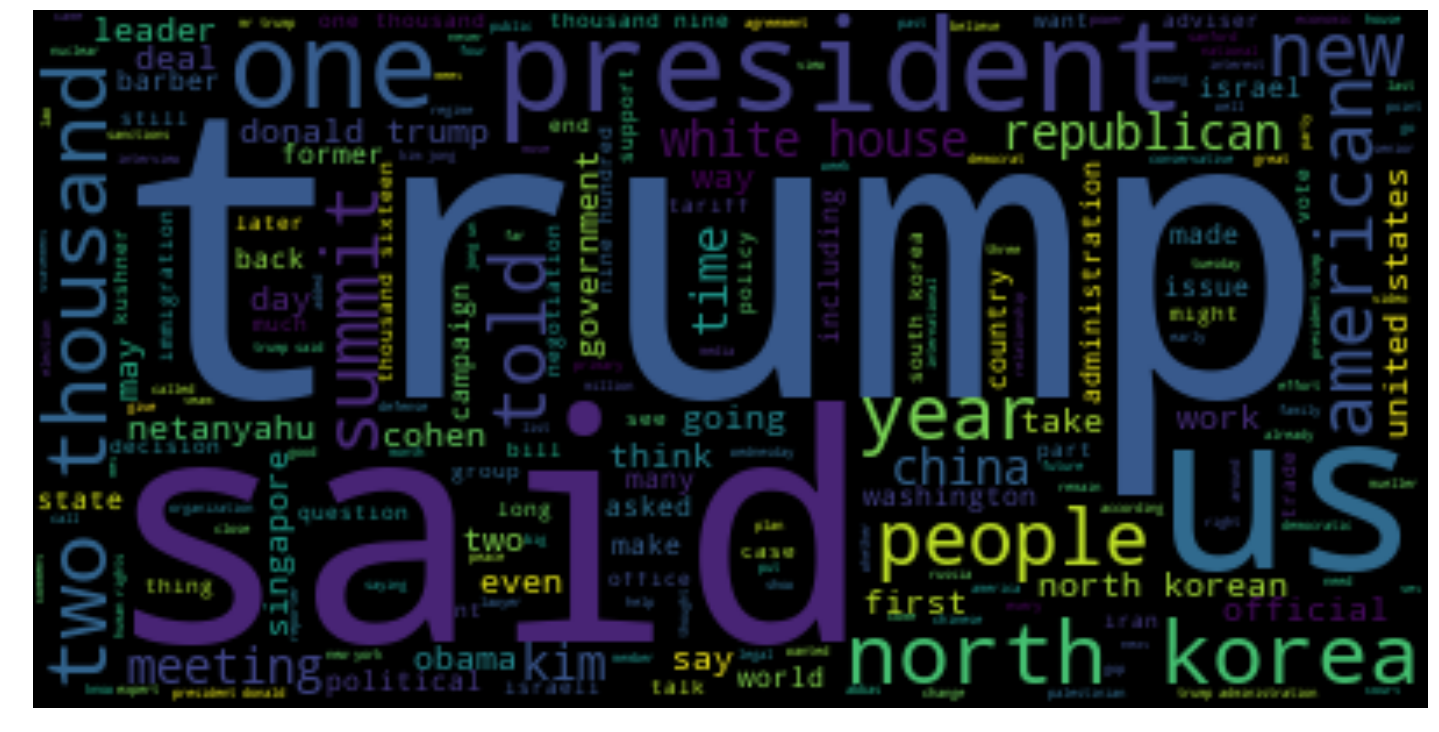

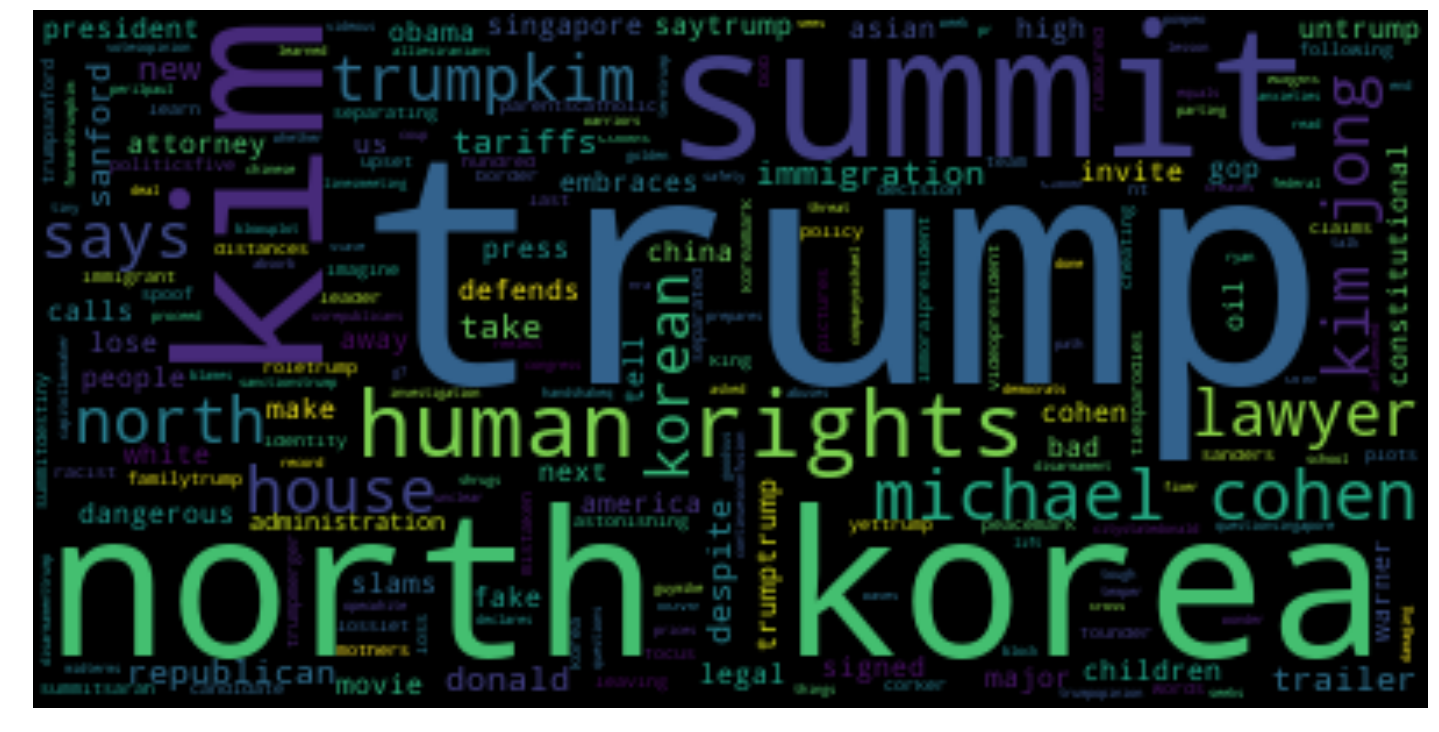

In [59]:
wordcloud = WordCloud().generate(word_cloud)

# Display the generated image:
# the matplotlib way:
plt.subplots(figsize=(25, 25))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

wordcloud = WordCloud().generate(word_cloud_title)

plt.subplots(figsize=(25, 25))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# lower max_font_size
#wordcloud = WordCloud(max_font_size=40).generate(text)
#plt.figure()
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")

plt.show()

In [15]:
merged_text = []
for text in news_article['processed']:
    merged_text = merged_text + text

In [16]:
merged_text

['north',
 'koreans',
 'last',
 'learn',
 'summit',
 'people',
 'north',
 'korea',
 'last',
 'hear',
 'unprecedented',
 'talks',
 'went',
 'leader',
 'sitting',
 'us',
 'president',
 'image',
 'copyright',
 'epa',
 'image',
 'caption',
 'sarah',
 'sanders',
 'president',
 'trump',
 'press',
 'secretary',
 'year',
 'sarah',
 'huckabee',
 'sanders',
 'white',
 'house',
 'press',
 'secretary',
 'planning',
 'leave',
 'administration',
 'according',
 'one',
 'us',
 'media',
 'outlet',
 'ms',
 'sanders',
 'responded',
 'story',
 'statement',
 'social',
 'media',
 'saying',
 'knew',
 'nothing',
 'story',
 'deny',
 'accuracy',
 'seemed',
 'trumpian',
 'first',
 'cbs',
 'news',
 'reported',
 'sanders',
 'deputy',
 'press',
 'secretary',
 'raj',
 'shah',
 'getting',
 'ready',
 'head',
 'exit',
 'ms',
 'sanders',
 'responded',
 'shortly',
 'afterwards',
 'twitter',
 'indignant',
 'manner',
 'skip',
 'twitter',
 'post',
 'presssec',
 'cbsnews',
 'know',
 'something',
 'plans',
 'future',
 'daught

In [17]:
freq_count = nlp.FreqDist(merged_text)

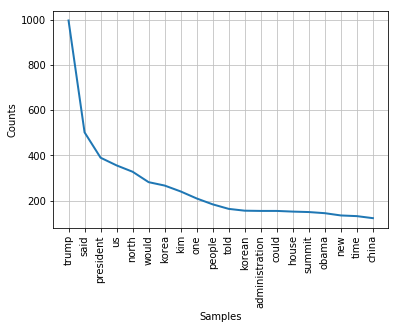

In [18]:
freq_count.plot(20,cumulative=False)

In [42]:
freq_count.

FreqDist({'trump': 996, 'said': 502, 'president': 390, 'us': 356, 'north': 328, 'would': 282, 'korea': 267, 'kim': 241, 'one': 210, 'people': 184, ...})

In [ ]:
plot.show()

In [19]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nlp.sent_tokenize(text) for word in nlp.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nlp.sent_tokenize(text) for word in nlp.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


tfidf_vectorizer = TfidfVectorizer(max_df=0.7, max_features=10000,
                                 min_df=0.3, stop_words='english',
                                 use_idf=True,tokenizer=tokenize_and_stem, ngram_range=(1,3)) #Optional to use normalize


In [20]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(news_article['cleantext']) #fit the vectorizer to synopses

terms = tfidf_vectorizer.get_feature_names()

CPU times: user 1.28 s, sys: 21 ms, total: 1.31 s
Wall time: 1.33 s


In [21]:
terms

['accord',
 'ad',
 'administr',
 'agre',
 'alreadi',
 'american',
 'ask',
 'believ',
 'chang',
 'close',
 'come',
 'comment',
 'continu',
 'countri',
 'critic',
 'day',
 'deal',
 'democrat',
 'elect',
 'email',
 'end',
 'expect',
 'follow',
 'forc',
 'govern',
 'great',
 'happen',
 'hope',
 'hous',
 'hundr',
 'includ',
 'issu',
 'jong',
 'kim',
 'kim jong',
 'know',
 'korea',
 'korean',
 'later',
 'leader',
 'like',
 'long',
 'look',
 'make',
 'mani',
 'meet',
 'month',
 'nation',
 'need',
 'negoti',
 'new',
 'news',
 'north',
 'north korea',
 'north korean',
 'nuclear',
 'offic',
 'offici',
 'peopl',
 'point',
 'polici',
 'polit',
 'possibl',
 'presid donald',
 'presid donald trump',
 'public',
 'question',
 'realli',
 'receiv',
 'recent',
 'remain',
 'report',
 'republican',
 'right',
 'say',
 'secur',
 'sign',
 'sinc',
 'singapor',
 'sixteen',
 'south',
 'state',
 'statement',
 'stori',
 'stori continu',
 'summit',
 'support',
 'talk',
 'thing',
 'think',
 'thousand',
 'time',
 'tol

In [22]:
dist = 1 - cosine_similarity(tfidf_matrix)

In [26]:
num_clusters = 4

km = KMeans(n_clusters=num_clusters,max_iter= 1000000)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()


CPU times: user 137 ms, sys: 4.52 ms, total: 142 ms
Wall time: 147 ms


In [27]:
cluster_df = pd.DataFrame(clusters,columns=['clusterID'])

In [28]:
cluster_df['clusterID'].value_counts()

2    36
0    23
1    22
3    12
Name: clusterID, dtype: int64

In [208]:
terms

['accord',
 'ad',
 'administr',
 'advis',
 'agre',
 'agreement',
 'aid',
 'alreadi',
 'america',
 'american',
 'ask',
 'attorney',
 'believ',
 'campaign',
 'carolina',
 'case',
 'chang',
 'china',
 'chines',
 'clear',
 'close',
 'cohen',
 'come',
 'comment',
 'commit',
 'compani',
 'concern',
 'confer',
 'conserv',
 'continu',
 'countri',
 'court',
 'critic',
 'day',
 'deal',
 'decis',
 'defens',
 'democrat',
 'denuclear',
 'depart',
 'discuss',
 'donald',
 'donald trump',
 'elect',
 'email',
 'end',
 'everi',
 'expect',
 'famili',
 'feder',
 'follow',
 'forc',
 'foreign',
 'good',
 'gop',
 'govern',
 'great',
 'group',
 'hand',
 'happen',
 'help',
 'hope',
 'hous',
 'human',
 'human right',
 'hundr',
 'imag',
 'immigr',
 'import',
 'includ',
 'intern',
 'issu',
 'joint',
 'jong',
 'kim',
 'kim jong',
 'know',
 'korea',
 'korean',
 'later',
 'law',
 'lawyer',
 'leader',
 'legal',
 'like',
 'list',
 'long',
 'look',
 'lot',
 'make',
 'mani',
 'media',
 'meet',
 'member',
 'militari',
 '

In [29]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in news_article['cleantext']:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [30]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

order_centroids


for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :20]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
'''
    print("Cluster %d titles:" % i, end='')
    for title in news_article['cleantext'].ix[i]:
        print(' %s' % title, end='')
        
'''

Top terms per cluster:

Cluster 0 words: b'news', b'white', b'white', b'reported', b'house', b'time', b'new', b'thousand', b'comment', b'emailed', b'deal', b'government', b'administration', b'signed', b'wednesday', b'year', b'work', b'told', b'including', b'look',

Cluster 1 words: b'administration', b'thousand', b'world', b'american', b'happen', b'people', b'policy', b'hundred', b'year', b'democratic', b'political', b'state', b'elections', b'government', b'nationals', b'leader', b'new', b'told', b'work', b'since',

Cluster 2 words: b'kim', b'north', b'korea', b'koreans', b'north', b'summit', b'north', b'singapore', b'nuclear', b'south', b'state', b'people', b'leader', b'jong', b'right', b'kim', b'american', b'country', b'meeting', b'negotiate',

Cluster 3 words: b'republicans', b'wednesday', b'house', b'supporters', b'south', b'elections', b'political', b'tuesday', b'signed', b'told', b'days', b'time', b'likes', b'adding', b'democratic', b'criticism', b'thousand', b'president', b'poli

/Users/devanshjani/.conda/envs/kycss_auric/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


'\n    print("Cluster %d titles:" % i, end=\'\')\n    for title in news_article[\'cleantext\'].ix[i]:\n        print(\' %s\' % title, end=\'\')\n        \n'

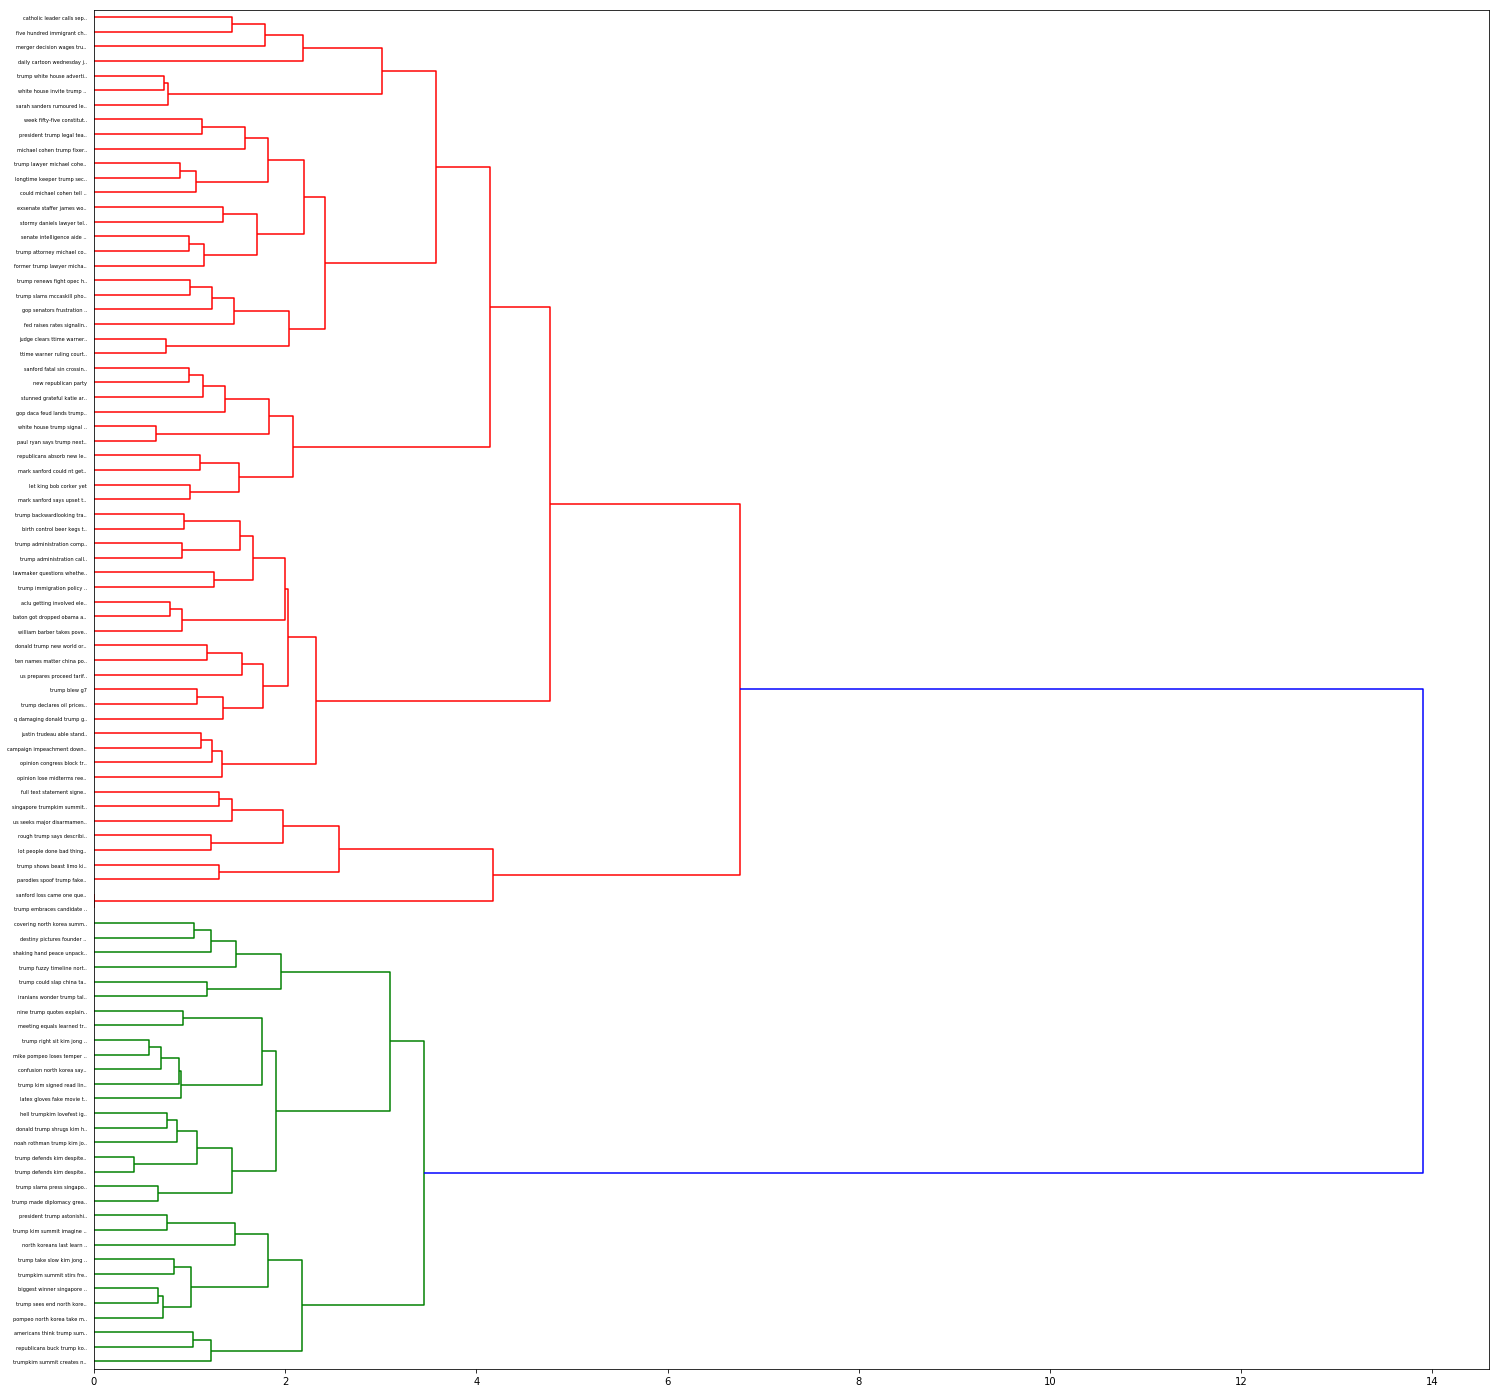

In [40]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig,ax = plt.subplots(figsize=(25, 25)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels = list_title);

In [41]:
#uncomment below to save figure
fig.savefig('ward_clusters.png', dpi=200)
#plt.savefig('ward_clusters.png', dpi=400) #save figure as ward_clusters

In [314]:
str(news_article['maintitle'])

'0     north koreans last learn ..\n1     sarah sanders rumoured le..\n2     trump kim summit imagine ..\n3     trump immigration policy ..\n4     five hundred immigrant ch..\n5     catholic leader calls sep..\n6     president trump legal tea..\n7     destiny pictures founder ..\n8     president trump astonishi..\n9     mark sanford says upset t..\n10        let king bob corker yet\n11    trump embraces candidate ..\n12    parodies spoof trump fake..\n13    mark sanford could nt get..\n14    merger decision wages tru..\n15    sanford loss came one que..\n16    singapore trumpkim summit..\n17    donald trump shrugs kim h..\n18    mike pompeo loses temper ..\n19    trump kim signed read lin..\n20    meeting equals learned tr..\n21    q damaging donald trump g..\n22    lot people done bad thing..\n23    us prepares proceed tarif..\n24    us seeks major disarmamen..\n25    trump sees end north kore..\n26    trumpkim summit creates n..\n27    iranians wonder trump tal..\n28    republicans a

In [299]:
linkage_matrix.shape

(92, 4)

In [308]:
sample = ''.join(random.choices(string.ascii_uppercase + string.digits, k=93))


In [39]:
list_title = list(news_article['maintitle'])